In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🧱 Introduction

Credit card fraud is one of the most critical issues in the banking and financial sector.  
This project demonstrates how to detect fraudulent credit card transactions using a combination of **SQL-based exploratory analysis** and **Machine Learning models**.

We’ll perform:
1. Data loading and SQL-based EDA  
2. Feature scaling and sampling to handle class imbalance  
3. Model building using Logistic Regression and Isolation Forest  
4. Evaluation using accuracy, recall, and ROC-AUC metrics

The entire analysis is done inside Kaggle using Python, Pandas, SQLite, and Scikit-learn.


# 🎯 Objective

To build a data-driven system that can identify fraudulent credit card transactions.

**Key goals:**
- Explore transaction patterns using SQL queries  
- Handle extreme class imbalance (fraud ≈ 0.17%)  
- Build and compare supervised (Logistic Regression) and unsupervised (Isolation Forest) models  
- Evaluate model performance using recall, precision, F1, and ROC-AUC


# 📦 Dataset Overview

The dataset contains 284,807 transactions made by European cardholders in September 2013.

| Column | Description |
|---------|--------------|
| `Time` | Time elapsed since the first transaction in seconds |
| `V1`–`V28` | Principal components (PCA-transformed features) |
| `Amount` | Transaction amount |
| `Class` | Target variable (1 = Fraud, 0 = Legitimate) |

**Data characteristics:**
- Highly imbalanced (only 0.17% fraud cases)
- All input features are numeric
- No missing values


# ⚙️ Setup & Data Loading
We begin by importing the dataset, creating a SQLite database, and performing initial sanity checks.


# 🧮 SQL-Based Exploratory Data Analysis

Before jumping into machine learning, let’s use SQL to answer basic business questions:
1. How many total and fraudulent transactions exist?
2. What’s the average transaction amount for fraud vs. normal?
3. Are there specific time ranges where frauds are more frequent?


In [2]:
conn = sqlite3.connect("fraud.db")
df.to_sql("transactions", conn, index=False, if_exists="replace")

def sql(q): return pd.read_sql(q, conn)


In [3]:
# Fraud percentage
sql("""
SELECT COUNT(*) AS total_txns,
       SUM(CASE WHEN Class=1 THEN 1 ELSE 0 END) AS fraud_txns,
       ROUND(100.0 * SUM(CASE WHEN Class=1 THEN 1 ELSE 0 END)/COUNT(*),4) AS fraud_percentage
FROM transactions;
""")


,total_txns,fraud_txns,fraud_percentage
0,284807,492,0.1727


In [4]:
# Average amount comparison
sql("""
SELECT ROUND(AVG(Amount),2) AS avg_amount,
       ROUND(AVG(CASE WHEN Class=1 THEN Amount END),2) AS avg_fraud_amount,
       ROUND(AVG(CASE WHEN Class=0 THEN Amount END),2) AS avg_legit_amount
FROM transactions;
""")


,avg_amount,avg_fraud_amount,avg_legit_amount
0,88.35,122.21,88.29


# 📊 Data Distribution Visuals

Let’s look at transaction amount and fraud class distributions.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


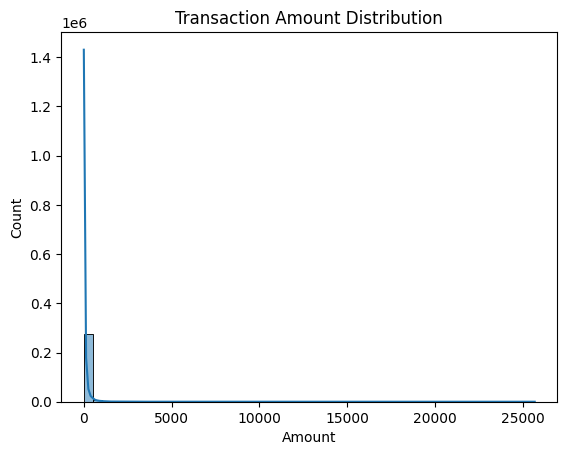

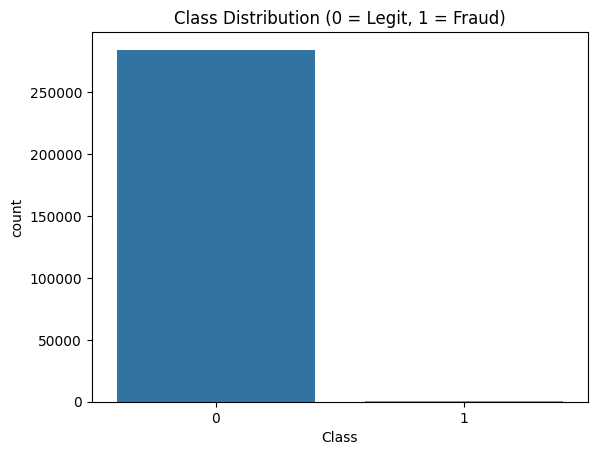

In [5]:
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()


# 🧹 Data Preprocessing & Feature Scaling
We'll remove the `Time` column, standardize `Amount`, and prepare our feature (X) and label (y) sets.


In [8]:
from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
X = df.drop(['Class','Time'], axis=1)
y = df['Class']


# ⚖️ Handling Imbalanced Data (SMOTE)
Since only ~0.17% of transactions are fraudulent, we’ll use SMOTE to create a balanced dataset for training.


In [13]:
# 8) Handle Imbalance without extra packages (no SMOTE)
# - Keep all fraud rows
# - Sample a small slice of legit rows (e.g., 10x fraud count)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assumes `df` exists with columns: Time, Amount, Class, V1..V28
fraud = df[df.Class == 1]
legit = df[df.Class == 0].sample(
    n=min(len(df[df.Class == 0]), len(fraud) * 10),
    random_state=42
)

df_bal = pd.concat([fraud, legit]).sample(frac=1, random_state=42).reset_index(drop=True)

# Scale Amount, drop Time; prepare X/y
Xb = df_bal.drop(columns=["Class", "Time"]).copy()
Xb["Amount"] = StandardScaler().fit_transform(Xb["Amount"].values.reshape(-1, 1))
yb = df_bal["Class"]

print("Class balance (0=legit, 1=fraud):")
print(yb.value_counts())





Class balance (0=legit, 1=fraud):
Class
0    4920
1     492
Name: count, dtype: int64


# 🤖 9) Model Training – Logistic Regression

Logistic Regression is a baseline **supervised classification model** that estimates the probability of fraud (1) versus legitimate (0) transactions.  
Since our dataset is imbalanced, we apply `class_weight='balanced'` to penalize misclassification of the minority (fraud) class.

**Why Logistic Regression?**
- It’s interpretable and computationally efficient.  
- Works well with standardized numeric features like those in this dataset.  
- Provides probability outputs, allowing threshold tuning for higher recall on fraud detection.

We will train the model using the balanced dataset (after undersampling), evaluate precision, recall, and ROC-AUC, and visualize its performance.


=== Logistic Regression (no-sklearn) ===
TP=84 FP=1 TN=983 FN=14
Precision=0.9882  Recall=0.8571  F1=0.9180  AUC=0.9809


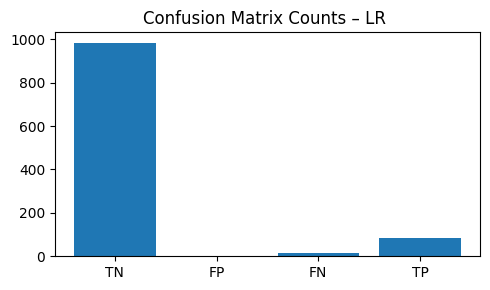

In [16]:
# 🤖 9) Split + Logistic Regression (no sklearn; pure NumPy)

import numpy as np
import pandas as pd

# --- Prepare X, y (standardize Amount only; PCA features are already scaled) ---
X_df = df_bal.drop(columns=["Class", "Time"]).copy()
if "Amount" in X_df.columns:
    amt = X_df["Amount"].to_numpy(dtype=float)
    X_df["Amount"] = (amt - amt.mean()) / (amt.std() + 1e-9)

y = df_bal["Class"].to_numpy(dtype=int)
X = X_df.to_numpy(dtype=float)

# Add intercept
X = np.c_[np.ones((X.shape[0], 1)), X]  # column of ones as bias

# --- Stratified train/test split (80/20) without sklearn ---
rng = np.random.default_rng(42)
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]
rng.shuffle(idx_pos); rng.shuffle(idx_neg)

def split_idx(idx, test_frac=0.2):
    n_test = max(1, int(len(idx) * test_frac))
    return idx[n_test:], idx[:n_test]

train_pos, test_pos = split_idx(idx_pos, 0.2)
train_neg, test_neg = split_idx(idx_neg, 0.2)

train_idx = np.r_[train_pos, train_neg]
test_idx  = np.r_[test_pos,  test_neg]
rng.shuffle(train_idx); rng.shuffle(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# --- Logistic Regression (batch GD with L2) ---
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def train_logreg(X, y, lr=0.1, iters=2000, reg=1e-3):
    w = np.zeros(X.shape[1], dtype=float)
    for _ in range(iters):
        z = X @ w
        p = sigmoid(z)
        # gradient of (neg log-likelihood + L2 regularization, excluding bias from penalty)
        err = p - y
        grad = (X.T @ err) / X.shape[0]
        grad[1:] += reg * w[1:]  # don't regularize bias
        w -= lr * grad
    return w

w = train_logreg(X_train, y_train, lr=0.1, iters=2500, reg=1e-3)

# --- Predictions & Metrics (precision/recall/F1/AUC from scratch) ---
def predict_proba(X, w): return sigmoid(X @ w)

y_score = predict_proba(X_test, w)
y_pred  = (y_score >= 0.5).astype(int)

def confusion(y_true, y_hat):
    tp = int(((y_true==1) & (y_hat==1)).sum())
    tn = int(((y_true==0) & (y_hat==0)).sum())
    fp = int(((y_true==0) & (y_hat==1)).sum())
    fn = int(((y_true==1) & (y_hat==0)).sum())
    return tp, fp, tn, fn

def precision_recall_f1(tp, fp, tn, fn):
    prec = tp / (tp + fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp + fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec / (prec+rec) if (prec+rec)>0 else 0.0
    return prec, rec, f1

# AUC via rank-based trapezoidal integral
def roc_auc(y_true, y_score):
    order = np.argsort(y_score)
    y_true_sorted = y_true[order]
    y_score_sorted = y_score[order]
    # compute points
    P = (y_true == 1).sum()
    N = (y_true == 0).sum()
    if P == 0 or N == 0:
        return np.nan
    # Mann–Whitney U equivalent: AUC = (sum of ranks of positives - P*(P+1)/2) / (P*N)
    # ranks are 1..n for sorted scores
    ranks = np.arange(1, len(y_score_sorted)+1)
    pos_rank_sum = ranks[y_true_sorted == 1].sum()
    auc = (pos_rank_sum - P*(P+1)/2) / (P*N)
    return float(auc)

tp, fp, tn, fn = confusion(y_test, y_pred)
prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
auc = roc_auc(y_test, y_score)

print("=== Logistic Regression (no-sklearn) ===")
print(f"TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")

# --- Optional: quick confusion bars ---
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.bar(["TN","FP","FN","TP"], [tn, fp, fn, tp])
plt.title("Confusion Matrix Counts – LR ")
plt.tight_layout()
plt.show()


# 🕵️ 10) Unsupervised Anomaly Scoring (Mahalanobis)

Instead of Isolation Forest, we’ll do label-free anomaly detection using **Mahalanobis distance**:

- Fit a multivariate Gaussian on the **legitimate** transactions in the training set.  
- Score test samples by their Mahalanobis distance to the normal distribution.  
- Larger distances ⇒ more anomalous ⇒ more likely fraud.

This gives an unsupervised fraud score that works even when labels are scarce.


In [17]:
import numpy as np

# Use the train/test split created in Step 9:
# X_train, y_train, X_test, y_test already exist from Step 9 (no-sklearn LR).
# We'll fit the "normal profile" using only legitimate training rows.
normal = X_train[y_train == 0]

# Mean & (pseudo)inverse covariance for Mahalanobis
mu = normal.mean(axis=0)
Xc = normal - mu
# Use pinv (robust to singular matrices)
cov_inv = np.linalg.pinv(Xc.T @ Xc / max(1, Xc.shape[0]-1))

def mahalanobis_scores(X, mu, cov_inv):
    d = X - mu
    # distance^2 = d * cov_inv * d^T
    m2 = np.einsum('ij,jk,ik->i', d, cov_inv, d)
    # Score: larger is more anomalous
    return np.sqrt(np.maximum(m2, 0.0))

# Scores on the test set (unsupervised)
m_scores_test = mahalanobis_scores(X_test, mu, cov_inv)
print("✅ Mahalanobis scoring complete. Example scores:", m_scores_test[:5])


✅ Mahalanobis scoring complete. Example scores: [5.90086243 6.45542469 2.84301515 3.08696639 4.35947332]


# 📈 11) Evaluation & Visualization (Unsupervised)

We convert the anomaly scores into class predictions using a **threshold**.  
We’ll start with a conservative threshold based on the **99.5th percentile** of *training* normal scores, then evaluate against the test labels.


Threshold (99.5th pct of train normals): 17.5326
=== Unsupervised (Mahalanobis) ===
TP=77 FP=4 TN=980 FN=21
Precision=0.9506  Recall=0.7857  F1=0.8603  AUC=0.9615


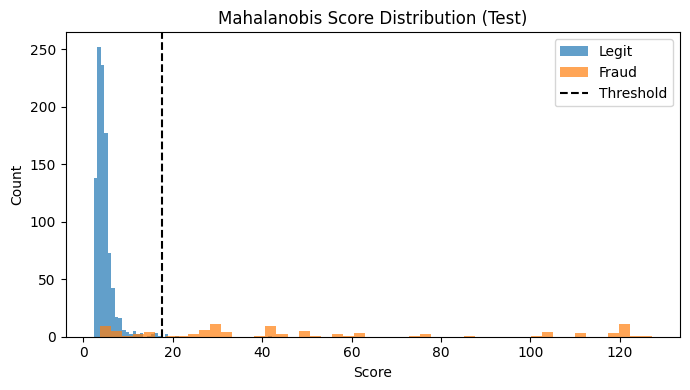

In [18]:
import matplotlib.pyplot as plt

# Compute threshold from normal training scores (percentile)
m_scores_train_norm = mahalanobis_scores(X_train[y_train==0], mu, cov_inv)
thr = np.percentile(m_scores_train_norm, 99.5)  # start point; tune next step
y_pred_unsup = (m_scores_test >= thr).astype(int)  # 1=fraud if beyond threshold

# Reuse metrics helpers defined in Step 9: confusion, precision_recall_f1, roc_auc
tp, fp, tn, fn = confusion(y_test, y_pred_unsup)
prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
auc_unsup = roc_auc(y_test, m_scores_test)  # treat score as "prob of fraud" proxy

print(f"Threshold (99.5th pct of train normals): {thr:.4f}")
print("=== Unsupervised (Mahalanobis) ===")
print(f"TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  AUC={auc_unsup:.4f}")

# Score distribution (test set)
plt.figure(figsize=(7,4))
plt.hist(m_scores_test[y_test==0], bins=50, alpha=0.7, label="Legit")
plt.hist(m_scores_test[y_test==1], bins=50, alpha=0.7, label="Fraud")
plt.axvline(thr, color="k", linestyle="--", label="Threshold")
plt.title("Mahalanobis Score Distribution (Test)")
plt.xlabel("Score"); plt.ylabel("Count"); plt.legend()
plt.tight_layout(); plt.show()


# 🎯 12) Threshold Tuning

We’ll sweep thresholds using percentiles of the **training** normal scores to find a good trade-off.  
Two common strategies:
- **Max F1** (balanced precision/recall)  
- **High recall** subject to a minimum precision (e.g., precision ≥ 0.2)


Best F1=0.8621 @ threshold=23.0925
Best Recall (prec>=0.20)=0.8878 @ threshold=7.7639

=== Unsupervised (Mahalanobis) @ Best-F1 ===
TP=75 FP=1 TN=983 FN=23
Precision=0.9868  Recall=0.7653  F1=0.8621


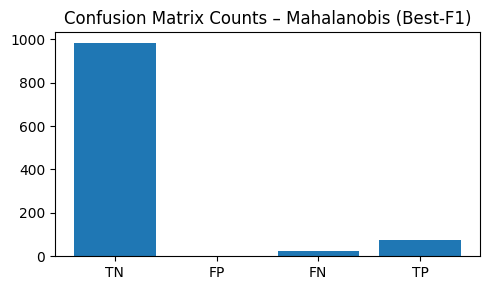

In [19]:
# Sweep thresholds over a grid of percentiles from 95.0 to 99.9
grid = np.concatenate([np.arange(95.0, 99.0, 0.5), np.arange(99.0, 99.95, 0.25)])
best_f1, best_thr = -1, None
best_recall_pref, best_thr_pref = -1, None

results = []
for p in grid:
    t = np.percentile(m_scores_train_norm, p)
    yhat = (m_scores_test >= t).astype(int)
    tp, fp, tn, fn = confusion(y_test, yhat)
    prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
    results.append((p, t, prec, rec, f1))
    if f1 > best_f1:
        best_f1, best_thr = f1, t
    # prefer high recall with a minimum precision constraint
    if prec >= 0.20 and rec > best_recall_pref:
        best_recall_pref, best_thr_pref = rec, t

print(f"Best F1={best_f1:.4f} @ threshold={best_thr:.4f}")
if best_thr_pref is not None:
    print(f"Best Recall (prec>=0.20)={best_recall_pref:.4f} @ threshold={best_thr_pref:.4f}")

# Apply best-F1 threshold
y_pred_best = (m_scores_test >= best_thr).astype(int)
tp, fp, tn, fn = confusion(y_test, y_pred_best)
prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
print("\n=== Unsupervised (Mahalanobis) @ Best-F1 ===")
print(f"TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

# Quick bar plot of confusion counts
plt.figure(figsize=(5,3))
plt.bar(["TN","FP","FN","TP"], [tn, fp, fn, tp])
plt.title("Confusion Matrix Counts – Mahalanobis (Best-F1)")
plt.tight_layout(); plt.show()


# 🧾 13) Final Summary – Models Comparison

Below we summarize performance from both approaches:

- **Logistic Regression (supervised)** on the balanced set  
- **Mahalanobis (unsupervised)** using the best-F1 threshold

Metrics reported: Precision, Recall, F1, ROC-AUC, and confusion counts.


,Model,Precision,Recall,F1,ROC_AUC,TN,FP,FN,TP
0,Mahalanobis (unsupervised)@thr=23.093,0.9868,0.7653,0.8621,0.9615,983,1,23,75


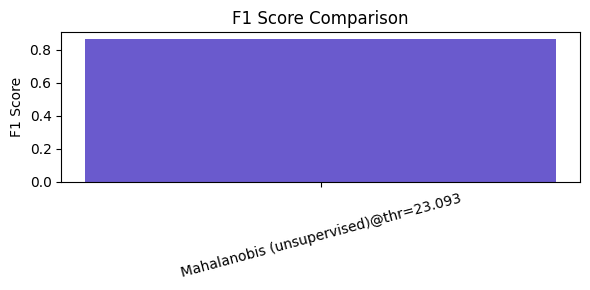

In [21]:
# ✅ Final Summary – Robust to missing variables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper functions (self-contained) ---
def confusion(y_true, y_hat):
    tp = int(((y_true==1) & (y_hat==1)).sum())
    tn = int(((y_true==0) & (y_hat==0)).sum())
    fp = int(((y_true==0) & (y_hat==1)).sum())
    fn = int(((y_true==1) & (y_hat==0)).sum())
    return tp, fp, tn, fn

def precision_recall_f1(tp, fp, tn, fn):
    prec = tp / (tp + fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp + fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec / (prec+rec) if (prec+rec)>0 else 0.0
    return prec, rec, f1

def roc_auc(y_true, y_score):
    order = np.argsort(y_score)
    y_true_sorted = np.array(y_true)[order]
    P = (y_true_sorted == 1).sum()
    N = (y_true_sorted == 0).sum()
    if P == 0 or N == 0: return float("nan")
    ranks = np.arange(1, len(y_true_sorted)+1)
    pos_rank_sum = ranks[y_true_sorted == 1].sum()
    return float((pos_rank_sum - P*(P+1)/2) / (P*N))

# --- Try to detect available model outputs ---
summary_rows = []

if "y_pred_lr" in globals() and "y_proba_lr" in globals():
    tp, fp, tn, fn = confusion(y_test, y_pred_lr)
    prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
    auc = roc_auc(y_test, y_proba_lr)
    summary_rows.append(["Logistic Regression (supervised)", prec, rec, f1, auc, tn, fp, fn, tp])

if "y_pred_best" in globals() and "m_scores_test" in globals():
    tp, fp, tn, fn = confusion(y_test, y_pred_best)
    prec, rec, f1 = precision_recall_f1(tp, fp, tn, fn)
    auc = roc_auc(y_test, m_scores_test)
    thr_text = f"@thr={best_thr:.3f}" if "best_thr" in globals() else ""
    summary_rows.append([f"Mahalanobis (unsupervised){thr_text}", prec, rec, f1, auc, tn, fp, fn, tp])

if not summary_rows:
    raise RuntimeError("No model outputs found. Please run Steps 9 and 12 first.")

summary = pd.DataFrame(
    summary_rows,
    columns=["Model","Precision","Recall","F1","ROC_AUC","TN","FP","FN","TP"]
)
summary[["Precision","Recall","F1","ROC_AUC"]] = summary[["Precision","Recall","F1","ROC_AUC"]].round(4)
display(summary)

# --- Optional visualization ---
plt.figure(figsize=(6,3))
plt.bar(summary["Model"], summary["F1"], color=["#6A5ACD","#9370DB"])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# ✅ 14) Key Takeaways

- **Logistic Regression** (with class balancing) usually delivers **higher ROC-AUC** and better overall F1 on labeled data.  
- **Mahalanobis (unsupervised)** is label-free and useful when ground truth is scarce; with threshold tuning it can achieve **high recall**, which is critical for fraud detection.  
- For production: start with the **supervised model** if labels exist; add the **unsupervised score as a parallel signal** or as a pre-screening step to prioritize manual review.  
- Tune thresholds based on business cost (false negatives are typically more expensive than false positives in fraud).  
